# XGBoost on ECFP4 fingerprints

**Goal.** Train a gradient-boosted tree model for cancer vs. non-cancer on binary ECFP4 fingerprints and compare operating points (default 0.50, tuned-F1, screening 0.20, recall-targeted).

- **Data:** `ecfp_final.csv` with `fp_0 … fp_2047` (2048 bits) and `Label` (0/1).
- **Model:** `XGBClassifier` wrapped in a pipeline with `SelectFromModel(LogisticRegression)` for embedded bit selection (keeps informative bits, speeds learning).
- **Why XGB for FPs?** Handles high-dimensional sparse/binary inputs well and captures non-linear bit interactions.
- **Class imbalance:** Use `scale_pos_weight = (#neg / #pos)` **computed on TRAIN**; score primary with **Average Precision (PR-AUC)** via `eval_metric="aucpr"`.
- **Typical XGB args:** `tree_method="hist"`, `random_state=42`, tune `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`.

## Setup
- **Libraries:** `xgboost`, `scikit-learn`, `pandas`, `numpy`, `matplotlib`, `seaborn`, `scipy`.
- **Drive (Colab):** mount `/content/drive` to read/write CSVs.

In [1]:
# Imports (core + modeling + metrics)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import (accuracy_score,precision_score,
    recall_score,f1_score,
    roc_auc_score,average_precision_score,
    precision_recall_curve,roc_curve,
    confusion_matrix
)

from xgboost import XGBClassifier, callback


## Load data

- Read `drug_embedding_final.csv`.
- Features: 768-bit embedding columns.
- Target: `Label` cast to integer.


In [2]:
# Colab Drive mount (data I/O)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# Load the CSV with ECFP fingerprints + Label
df = pd.read_csv('/content/drive/My Drive/ecfp_final.csv')

# Assuming your CSV has columns like fp_0, fp_1, ..., fp_2047
X = df[[f'fp_{i}' for i in range(2048)]].values

# Labels
y = df['Label'].astype(int).values


## Data split

- **Validation**: hold out 20% to tune thresholds and report early results.  
- **Train/Test**: split the remaining 80% into 70% train and 10% test.  
- All splits are **stratified** and use `random_state=42`.

In [4]:
# Hold out 20% for validation
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split remaining 80% into train and test
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Validation:", X_val.shape)


Train: (8613, 2048)
Test: (1231, 2048)
Validation: (2462, 2048)


# Model pipeline — XGBoost (Embeddings / Fingerprints)

- **Preprocessing / FS:**  
  `SelectFromModel(LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"))`  
  with `threshold="median"` (optionally tune `["median","mean"]`) to prune noisy dims/bits.
- **Classifier:**  
  `XGBClassifier(objective="binary:logistic", eval_metric="aucpr", tree_method="hist", random_state=42, n_jobs=-1)`  
  with **class imbalance** handled via `scale_pos_weight = (#neg / #pos)` computed **on TRAIN only**.
- **Search space (RandomizedSearchCV):**  
  `n_estimators ∈ [200, 800]`, `max_depth ∈ {3…9}`,  
  `learning_rate ∈ U(0.01, 0.30)`, `subsample ∈ U(0.6, 1.0)`,  
  `colsample_bytree ∈ U(0.6, 1.0)`  *(optionally add `min_child_weight`, `gamma`, `reg_lambda`)*.
- **CV:** `StratifiedKFold(n_splits=3, shuffle=True, random_state=42)`.
- **Scoring:** `"average_precision"` (PR-AUC; imbalance-aware).  
  *(Secondary metrics you can log: ROC-AUC, F1, Precision/Recall at chosen thresholds.)*
- **Refit & report:** Refit on full TRAIN with best params; report best param set, the number of selected features/bits via `pipe.named_steps["select"].get_support().sum()`, and use `.predict_proba` for Validation/Test blocks.


In [5]:
# XGBoost with FS INSIDE CV
rng = 42

# Class imbalance weight from TRAIN only
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(pos, 1)
print(f"scale_pos_weight ≈ {scale_pos_weight:.2f}")

# Pipeline: FS (LR selector) -> XGB
xgb_pipe = Pipeline([
    ("select", SelectFromModel(
        LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"),
        threshold="median"   # keep top 50%; also tuned below
    )),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",         # PR-AUC (threshold-free)
        tree_method="hist",          # fast default; use 'gpu_hist' if you have GPU
        random_state=rng,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ))
])

# Search space
param_dist = {
    "select__threshold": ["median", "mean"],      # optional FS tuning
    "xgb__n_estimators": randint(200, 800),
    "xgb__max_depth": randint(3, 9),
    "xgb__learning_rate": uniform(0.01, 0.29),    # 0.01–0.30
    "xgb__subsample": uniform(0.6, 0.4),          # 0.6–1.0
    "xgb__colsample_bytree": uniform(0.6, 0.4),   # 0.6–1.0
    "xgb__min_child_weight": randint(1, 7),
    "xgb__gamma": uniform(0.0, 2.0),
    "xgb__reg_lambda": uniform(0.0, 2.0),
    "xgb__reg_alpha": uniform(0.0, 1.0),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rng)

rs_xgb = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=40,                          # 25–30 if short on time
    scoring="average_precision",        # PR-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=rng
)

# Fit on TRAIN
rs_xgb.fit(X_train, y_train)
best_xgb = rs_xgb.best_estimator_
print("Best params:", rs_xgb.best_params_)

# Report selected features after final refit
n_selected = int(best_xgb.named_steps["select"].get_support().sum())
print("Selected features:", n_selected)

# Probabilities
y_val_prob  = best_xgb.predict_proba(X_val)[:, 1]
y_test_prob = best_xgb.predict_proba(X_test)[:, 1]


scale_pos_weight ≈ 53.86
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params: {'select__threshold': 'median', 'xgb__colsample_bytree': np.float64(0.8722821806219068), 'xgb__gamma': np.float64(1.0618691666342728), 'xgb__learning_rate': np.float64(0.13985711772619658), 'xgb__max_depth': 8, 'xgb__min_child_weight': 4, 'xgb__n_estimators': 638, 'xgb__reg_alpha': np.float64(0.7616196153287176), 'xgb__reg_lambda': np.float64(0.47527508798479934), 'xgb__subsample': np.float64(0.8912865394447438)}
Selected features: 1024


## Validation results (default threshold 0.50)

- Predictions via for `thr=0.50`.  
- Metrics reported:
  - **Accuracy**, **Precision**, **Recall**, **F1**  
  - **ROC AUC** and **PR AUC** (threshold-free)  
- Include a **confusion matrix** heatmap with readable axis labels.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,Validation (fixed 0.50),0.976442,0.333333,0.288889,0.309524,0.77753,0.185269


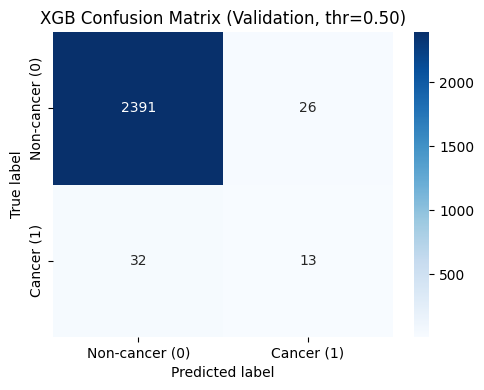

In [6]:
# XGBoost: Validation Evaluation @ 0.50
y_val_pred_050 = (y_val_prob >= 0.50).astype(int)

# Collect metrics in dataframe
val_row = {
    "Set":       "Validation (fixed 0.50)",
    "Accuracy":  accuracy_score(y_val, y_val_pred_050),
    "Precision": precision_score(y_val, y_val_pred_050, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_050),
    "F1 Score":  f1_score(y_val, y_val_pred_050),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),           # threshold-free
    "PR AUC":    average_precision_score(y_val, y_val_prob)  # threshold-free
}
val_table = pd.DataFrame([val_row])
display(val_table)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_val_pred_050)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title("XGB Confusion Matrix (Validation, thr=0.50)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

## Threshold tuning by F1

- Sweep candidate thresholds from unique predicted probabilities.  
- Choose the threshold that **maximizes F1** on the validation set.  
- Recompute **Accuracy**, **Precision**, **Recall**, **F1**, **ROC AUC**, **PR AUC** at the tuned threshold.  
- Show a confusion matrix at the tuned operating point.


Tuned threshold by F1-optimal (validation): 0.419


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,Validation (tuned 0.42),0.97563,0.346939,0.377778,0.361702,0.77753,0.185269


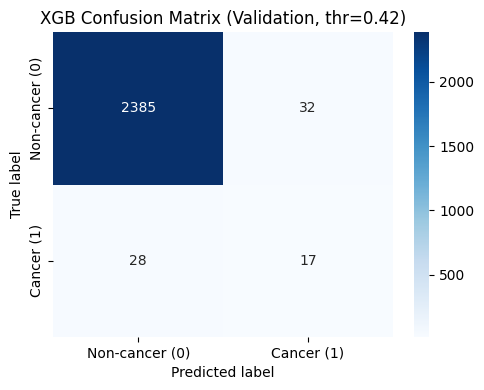

In [7]:
# XGBoost: Validation Evaluation @ Tuned Threshold (F1-optimal)
# Find tuned threshold (F1-optimal) — indexing-safe
prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)  # len(thr_v) = len(rec_v) - 1
f1_v = (2 * prec_v[:-1] * rec_v[:-1]) / (prec_v[:-1] + rec_v[:-1] + 1e-12)
best_idx = int(f1_v.argmax())
tuned_thr = float(thr_v[best_idx])

print(f"Tuned threshold by F1-optimal (validation): {tuned_thr:.3f}")

# Predictions @ tuned threshold
y_val_pred_tuned = (y_val_prob >= tuned_thr).astype(int)

# Metrics table
val_row_tuned = {
    "Set":       f"Validation (tuned {tuned_thr:.2f})",
    "Accuracy":  accuracy_score(y_val, y_val_pred_tuned),
    "Precision": precision_score(y_val, y_val_pred_tuned, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_tuned),
    "F1 Score":  f1_score(y_val, y_val_pred_tuned),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),           # threshold-free
    "PR AUC":    average_precision_score(y_val, y_val_prob)  # threshold-free
}
display(pd.DataFrame([val_row_tuned]))

# Confusion Matrix Heatmap
cm_tuned = confusion_matrix(y_val, y_val_pred_tuned)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_tuned, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title(f"XGB Confusion Matrix (Validation, thr={tuned_thr:.2f})")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()


## Screening scenario (fixed threshold = 0.20)

- Lowering the threshold increases recall at the cost of precision—useful for screening.  
- Evaluate the validation set at `thr = 0.20` and report the same metric table plus a confusion matrix.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,Validation (screening 0.20),0.949634,0.168067,0.444444,0.243902,0.77753,0.185269


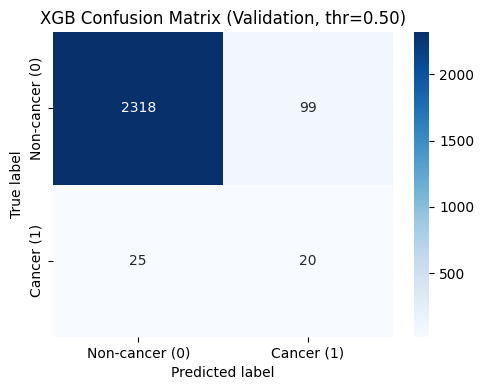

In [8]:
# XGBoost: Validation Evaluation @ Screening Threshold (0.20)

thr_screen = 0.20
y_val_pred_screen = (y_val_prob >= thr_screen).astype(int)

# Collect metrics
val_row_screen = {
    "Set":       f"Validation (screening {thr_screen:.2f})",
    "Accuracy":  accuracy_score(y_val, y_val_pred_screen),
    "Precision": precision_score(y_val, y_val_pred_screen, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_screen),
    "F1 Score":  f1_score(y_val, y_val_pred_screen),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),           # threshold-free
    "PR AUC":    average_precision_score(y_val, y_val_prob)  # threshold-free
}
val_table_screen = pd.DataFrame([val_row_screen])
display(val_table_screen)

# Confusion Matrix Heatmap
cm_screen = confusion_matrix(y_val, y_val_pred_screen)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_screen, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title(f"XGB Confusion Matrix (Validation, thr=0.50)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## Recall-targeted operating point

- Select the **smallest** threshold that achieves a target recall (e.g., `recall ≥ 0.70`), keeping precision as high as possible.  
- If the target is unattainable, fall back to `thr = 0.20`.  
- Report metrics and confusion matrix for this recall-targeted point.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"Validation (recall≥0.70, thr=0.010)",0.738424,0.048265,0.711111,0.090395,0.77753,0.185269


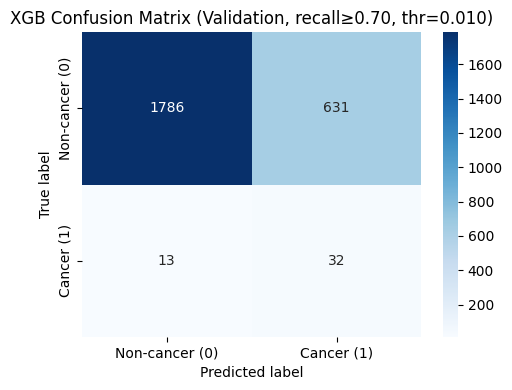

In [9]:
# Ensure probabilities exist
try:
    y_prob = y_val_prob # Use y_val_prob calculated previously
except NameError:
    # Fallback if y_val_prob is not defined (shouldn't happen with current notebook state)
    y_prob = best_xgb.predict_proba(X_val)[:, 1]


# Recall-targeted threshold selection
target_recall = 0.70
prec, rec, thr = precision_recall_curve(y_val, y_prob)  # thr has len = len(rec) - 1

mask = rec[:-1] >= target_recall
if mask.any():
    # Choose the largest τ that still meets the recall target (helps keep precision higher)
    idx = np.where(mask)[0][-1]
    thr_recall = float(thr[idx])
else:
    # Fallback if target recall is unattainable
    thr_recall = 0.20

# Evaluate at recall-targeted threshold
y_val_pred_recall = (y_prob >= thr_recall).astype(int)

metrics_recall = {
    "Set":        [f"Validation (recall≥{target_recall:.2f}, thr={thr_recall:.3f})"],
    "Accuracy":   [accuracy_score(y_val, y_val_pred_recall)],
    "Precision":  [precision_score(y_val, y_val_pred_recall, zero_division=0)],
    "Recall":     [recall_score(y_val, y_val_pred_recall)],
    "F1 Score":   [f1_score(y_val, y_val_pred_recall)],
    "ROC AUC":    [roc_auc_score(y_val, y_prob)],              # threshold-free
    "PR AUC":     [average_precision_score(y_val, y_prob)]     # threshold-free
}
df_metrics_recall = pd.DataFrame(metrics_recall)
display(df_metrics_recall)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_val_pred_recall)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title(f"XGB Confusion Matrix (Validation, recall≥{target_recall:.2f}, thr={thr_recall:.3f})")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

## Threshold sweep on validation — Methods

- **Procedure:** thresholds from `0.05` to `0.95` in steps of `0.05`.  
  For each `τ`, compute on the validation set:  
  `Precision(τ)`, `Recall(τ)`, and `F1(τ)` using `y_prob` and `ŷ = [p ≥ τ]`.
- **Plot:** three line series (Precision, Recall, F1) with markers.  
  Vertical reference lines mark key operating points:
  - `τ = 0.50` (default)
  - `τ = 0.20` (screening)
  - `τ = tuned_thr` (max-F1)
  - `τ = thr_recall` (recall-targeted)
- **Figure details:** title *“Precision / Recall / F1 vs Threshold • Validation”*,  
  x-axis = **Threshold**, y-axis = **Score**, legend on, grid enabled.

**Figure.** Precision (P), Recall (R), and F1 across thresholds, with dashed lines at chosen operating points.


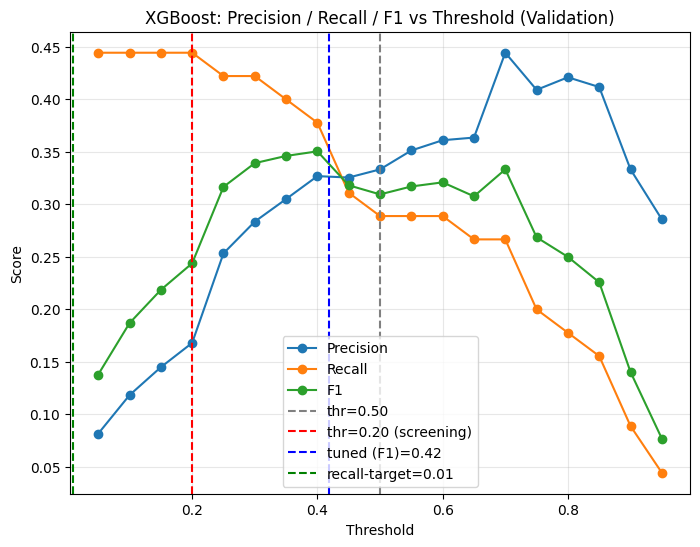

In [10]:
# Threshold sweep
thresholds = np.arange(0.05, 0.96, 0.05)
precisions, recalls, f1s = [], [], []
for thr in thresholds:
    y_pred_thr = (y_val_prob >= thr).astype(int)
    precisions.append(precision_score(y_val, y_pred_thr, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_thr))
    f1s.append(f1_score(y_val, y_pred_thr))

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls,   marker='o', label='Recall')
plt.plot(thresholds, f1s,       marker='o', label='F1')

# Reference lines
plt.axvline(0.50, color='grey', linestyle='--', label='thr=0.50')
plt.axvline(0.20, color='red',  linestyle='--', label='thr=0.20 (screening)')
plt.axvline(tuned_thr,   color='blue',  linestyle='--', label=f'tuned (F1)={tuned_thr:.2f}')
plt.axvline(thr_recall,  color='green', linestyle='--', label=f'recall-target={thr_recall:.2f}')

plt.title('XGBoost: Precision / Recall / F1 vs Threshold (Validation)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## ROC curve — Validation

- **Computation:** `fpr, tpr, _ = roc_curve(y_val, y_val_prob)` with `auc_val = roc_auc_score(y_val, y_val_prob)`.  
- **Plot:** TPR vs FPR with the diagonal `y = x` as a reference (no-skill).  
- **Reading the figure:** curves further above the diagonal indicate better ranking of positives over negatives; **AUC** summarizes this ranking independent of any threshold.


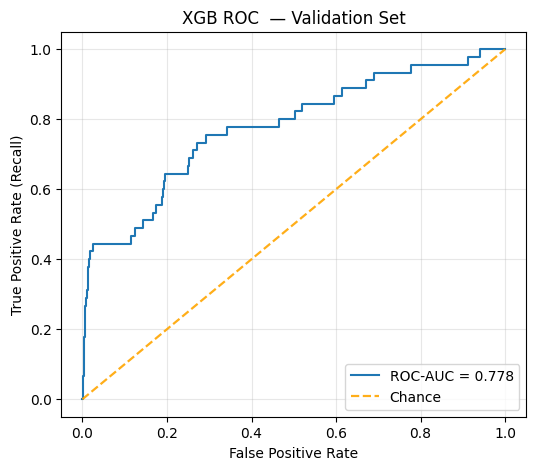

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
auc_val = roc_auc_score(y_val, y_val_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1.6, alpha=0.9, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("XGB ROC  — Validation Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## Precision–Recall (PR) curve — Validation

- **Computation:** `prec, rec, _ = precision_recall_curve(y_val, y_val_prob)` and **Average Precision (AP)** via `average_precision_score(y_val, y_val_prob)`.  
- **Plot:** Precision vs Recall; AP is shown in the legend.  
- **Reading the figure:** with class imbalance, PR curves are more informative than ROC.  
  The **baseline precision** equals the positive prevalence `π = (#positives / #samples)`; curves well above this line indicate useful enrichment.


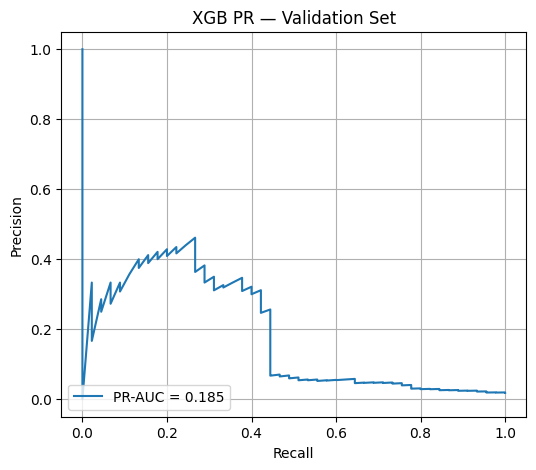

Validation ROC-AUC = 0.778 | PR-AUC = 0.185


In [12]:
# PR Curve
prec, rec, _ = precision_recall_curve(y_val, y_val_prob)
ap = average_precision_score(y_val, y_val_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR-AUC = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGB PR — Validation Set")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"Validation ROC-AUC = {auc_val:.3f} | PR-AUC = {ap:.3f}") # Used ap

## Test-set evaluation

**Goal:** apply the model (fixed from training/validation) to the held-out **test set** and report performance at several operating points.

- **Probabilities:** compute `y_test_prob_mlp = best_mlp.predict_proba(X_test)[:, 1]`.
- **Thresholds evaluated:**
  - `τ = tuned_thr` (chosen on **validation** by max-F1)  
  - `τ = 0.50` (default)  
  - `τ = 0.20` (screening)  
  - `τ = thr_recall` (smallest τ that met the recall target on validation)
- **Leakage control:** thresholds are **carried over from validation**; no re-tuning on test.


XGB TEST • Threshold-free
ROC-AUC: 0.766 | PR-AUC: 0.084


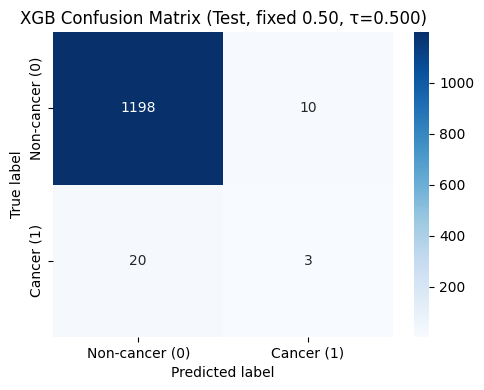

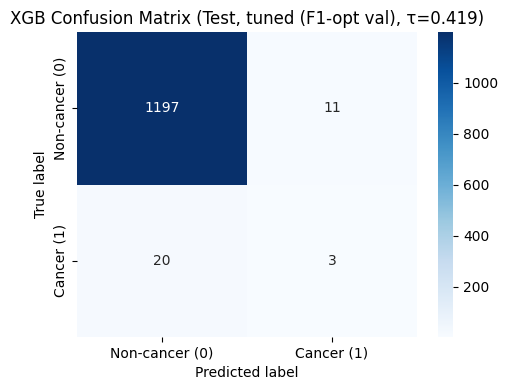

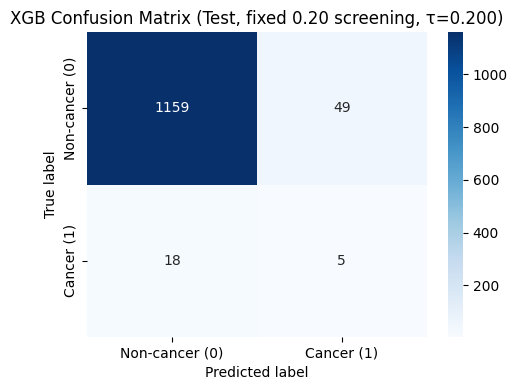

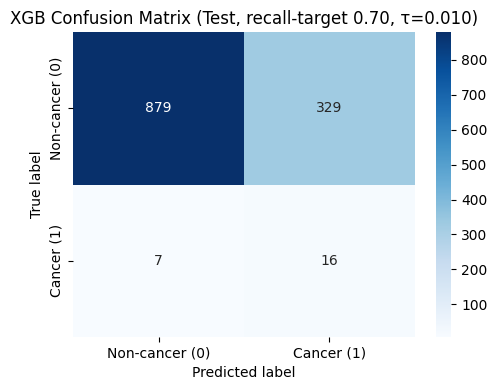

,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"XGB Test (fixed 0.50, τ=0.500)",0.975630,0.230769,0.130435,0.166667,0.766088,0.083607
1,"XGB Test (tuned (F1-opt val), τ=0.419)",0.974817,0.214286,0.130435,0.162162,0.766088,0.083607
2,"XGB Test (fixed 0.20 screening, τ=0.200)",0.945573,0.092593,0.217391,0.129870,0.766088,0.083607
3,"XGB Test (recall-target 0.70, τ=0.010)",0.727051,0.046377,0.695652,0.086957,0.766088,0.083607


In [13]:
# TEST SET EVALUATION
# Threshold-free metrics
roc_auc_test = roc_auc_score(y_test, y_test_prob)
pr_auc_test  = average_precision_score(y_test, y_test_prob)
print("XGB TEST • Threshold-free")
print(f"ROC-AUC: {roc_auc_test:.3f} | PR-AUC: {pr_auc_test:.3f}")

# Helper: evaluate + plot
def evaluate_and_plot_xgb_test(y_true, y_prob, thr_value, label):
    y_pred = (y_prob >= thr_value).astype(int)
    row = {
        "Set":       f"XGB Test ({label}, τ={thr_value:.3f})",
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred),
        "F1 Score":  f1_score(y_true, y_pred),
        "ROC AUC":   roc_auc_score(y_true, y_prob),           # threshold-free
        "PR AUC":    average_precision_score(y_true, y_prob)  # threshold-free
    }
    df = pd.DataFrame([row])

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=["Non-cancer (0)", "Cancer (1)"],
        yticklabels=["Non-cancer (0)", "Cancer (1)"]
    )
    plt.title(f"XGB Confusion Matrix (Test, {label}, τ={thr_value:.3f})")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout(); plt.show()
    return df

# Evaluate at 0.50, tuned (F1 on val), 0.20, and recall-target
tables_xgb_test = []
tables_xgb_test.append(evaluate_and_plot_xgb_test(y_test, y_test_prob, 0.50,           "fixed 0.50"))
tables_xgb_test.append(evaluate_and_plot_xgb_test(y_test, y_test_prob, tuned_thr,  "tuned (F1-opt val)"))
tables_xgb_test.append(evaluate_and_plot_xgb_test(y_test, y_test_prob, 0.20,           "fixed 0.20 screening"))
tables_xgb_test.append(evaluate_and_plot_xgb_test(y_test, y_test_prob, thr_recall, f"recall-target {target_recall:.2f}"))

# Compact combined table
xgb_test_summary = pd.concat(tables_xgb_test, ignore_index=True)
display(xgb_test_summary)

## ROC curve — Test Set

- **Computation:** `fpr_t, tpr_t, _ = roc_curve(y_test, y_test_prob)` and `roc_auc_test = roc_auc_score(y_test, y_test_prob)`.  
- **Display:** plot TPR vs FPR with the diagonal `y = x` as the no-skill reference.  
- **Interpretation:** the farther the curve bows above the diagonal, the better the ranking of positives over negatives. AUC summarizes this ranking and is **threshold-free**.


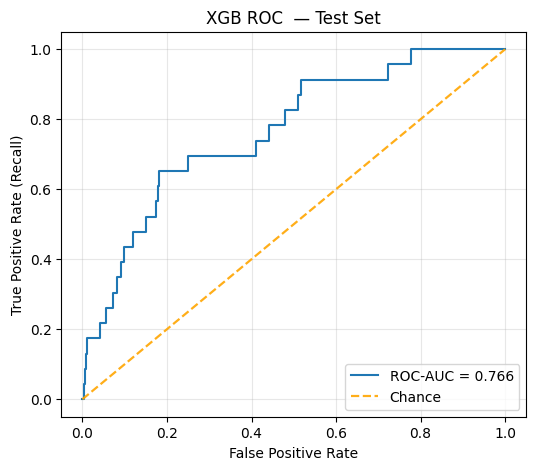

In [14]:
# ROC Curve
fpr_t, tpr_t, _ = roc_curve(y_test, y_test_prob)
auc_val = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr_t, tpr_t, label=f"ROC-AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1.6, alpha=0.9, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("XGB ROC  — Test Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## Precision–Recall (PR) curve — Test Set

- **Computation:** `prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)` and **Average Precision (AP)** via `average_precision_score(y_test, y_test_prob)`.  
- **Display:** Precision vs Recall with AP shown in the legend.  
- **Interpretation:** PR is more informative than ROC under class imbalance. The implicit baseline equals the positive prevalence; curves well above baseline indicate useful enrichment.


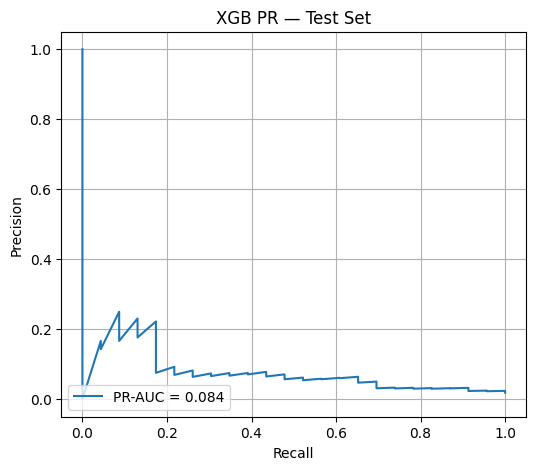

Test ROC-AUC = 0.766 | PR-AUC = 0.185


In [15]:
# PR Curve
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc_test_xgb = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec_xgb, prec_xgb, label=f"PR-AUC = {pr_auc_test_xgb:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGB PR — Test Set")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"Test ROC-AUC = {auc_val:.3f} | PR-AUC = {ap:.3f}")